# Análisis del dataset de Task 3

Exploración de datos y correlaciones entre `hours_since_watering` y las variables de sensores (sensor_*).

Objetivos:
- Cargar y validar el dataset enriquecido con sensores.
- Resumen de filas/columnas, tipos y valores perdidos.
- Identificar columnas de sensores numéricas.
- Calcular correlaciones (Pearson y Spearman) de `hours_since_watering` con sensores.
- Visualizar distribuciones y relaciones clave.

In [16]:
# Imports y configuración
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

REPO_ROOT = Path("/home/gti/ibmcp").resolve()#.parents[1]
CSV_PREFERRED = REPO_ROOT / 'results_task3' / 'plant_ultrasound_dataset_with_sensors.csv'
#CSV_FALLBACK  = REPO_ROOT / 'results_task3' / 'plant_ultrasound_dataset.csv'
#CSV_PATH = CSV_PREFERRED if CSV_PREFERRED.exists() else CSV_FALLBACK
CSV_PATH = CSV_PREFERRED
CSV_PATH.exists(), CSV_PATH

(True,
 PosixPath('/home/gti/ibmcp/results_task3/plant_ultrasound_dataset_with_sensors.csv'))

In [17]:
# Carga del dataset
if not CSV_PATH.exists():
    raise FileNotFoundError(f'No se encontró el CSV en {CSV_PATH}')
df = pd.read_csv(CSV_PATH)
print(f'Ruta: {CSV_PATH}')
print(df.shape)
df.head(3)

Ruta: /home/gti/ibmcp/results_task3/plant_ultrasound_dataset_with_sensors.csv
(5813, 32)


,audio_path,session,channel,plant_id,species,genotype,recording_time,last_watering_time,hours_since_watering,days_since_watering,session_dir,treatment,soil_sensors,sowing,transplant,water_stress,water_status,hours_normalized,days_normalized,hour,time_bin,sensor_humidity,sensor_voltage,sensor_wifi_rssi,sensor_co2,sensor_light,sensor_soil_temp,sensor_soil_moisture,sensor_soil_ph,sensor_time,sensor_delta_minutes,sensor_source
0,data/PUA.02/audiofiles/PUA076/ch2PUA_2025-02-0...,PUA076,ch2,#70,Nicotiana benthamiana,wt,2025-02-05 05:44:50,2025-01-30 15:48:58,133.931111,5.580463,PUA.02,NaN,"ph1,temphum1",NaN,2024-12-23_12-00-00,1,stressed,0.331840,0.331840,5,132-144h,37.5082,NaN,NaN,NaN,2172.00,NaN,NaN,NaN,2025-02-05 05:46:45,1.916667,sensor1
1,data/PUA.02/audiofiles/PUA076/ch2PUA_2025-02-0...,PUA076,ch2,#70,Nicotiana benthamiana,wt,2025-02-05 08:54:56,2025-01-30 15:48:58,137.099444,5.712477,PUA.02,NaN,"ph1,temphum1",NaN,2024-12-23_12-00-00,1,stressed,0.339690,0.339690,8,132-144h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-05 08:47:17,7.650000,sensor1
2,data/PUA.02/audiofiles/PUA076/ch3PUA_2025-02-0...,PUA076,ch3,#71,Nicotiana benthamiana,wt,2025-02-03 00:46:11,2025-01-30 15:48:58,80.953611,3.373067,PUA.02,NaN,NaN,NaN,2024-12-23_12-00-00,1,stressed,0.200578,0.200578,0,72-84h,40.4410,NaN,NaN,NaN,0.15,NaN,NaN,NaN,2025-02-03 00:46:34,0.383333,sensor2


### Explicación: estructura del dataset
- `hours_since_watering` es el objetivo a predecir (horas desde el último riego).
- Columnas `sensor_*` contienen lecturas de sensores; se intentan convertir a numéricas para análisis.
- `audio_path`/`full_path` y metadatos (p.ej., `channel`, `session`, `recording_time`) describen cada grabación.
- Verifica dimensiones y primeras filas para confirmar que los datos esperados están presentes y detectar valores nulos.

In [18]:
# Información básica y valores perdidos
display(df.dtypes)
missing = df.isna().mean().sort_values(ascending=False)
print('Escala de missing_frac: 0.0 = sin valores perdidos; 1.0 = 100% perdidos')
out = pd.DataFrame({
    'missing_frac': missing,
    'missing_pct': (missing * 100).round(2)
})
out[out['missing_frac'] > 0].head(30)

audio_path               object
session                  object
channel                  object
plant_id                 object
species                  object
genotype                 object
recording_time           object
last_watering_time       object
hours_since_watering    float64
days_since_watering     float64
session_dir              object
treatment               float64
soil_sensors             object
sowing                  float64
transplant               object
water_stress              int64
water_status             object
hours_normalized        float64
days_normalized         float64
hour                      int64
time_bin                 object
sensor_humidity         float64
sensor_voltage          float64
sensor_wifi_rssi        float64
sensor_co2              float64
sensor_light            float64
sensor_soil_temp        float64
sensor_soil_moisture    float64
sensor_soil_ph          float64
sensor_time              object
sensor_delta_minutes    float64
sensor_s

Escala de missing_frac: 0.0 = sin valores perdidos; 1.0 = 100% perdidos


,missing_frac,missing_pct
sowing,1.000000,100.00
treatment,1.000000,100.00
sensor_wifi_rssi,0.998968,99.90
sensor_soil_ph,0.997076,99.71
sensor_soil_moisture,0.997076,99.71
sensor_soil_temp,0.997076,99.71
sensor_co2,0.995527,99.55
sensor_humidity,0.783933,78.39
sensor_light,0.783933,78.39
sensor_voltage,0.773095,77.31


### Interpretación de valores perdidos
- La columna `missing_frac` está en [0, 1]: 0 = sin valores perdidos, 1 = 100% perdidos (peor).
- La columna `missing_pct` es el porcentaje equivalente.
- < 5%: bajo, imputación simple (mediana) suele ser suficiente.
- 5–20%: medio, evaluar impacto; imputación más informada o modelos robustos.
- > 20%: alto, considerar descartar la variable o investigar la causa.
- Nota: en este cuaderno se imputa con mediana para sensores, por robustez y simplicidad.

In [19]:
# Identificar columnas de sensores y objetivo
TARGET = 'hours_since_watering'
if TARGET not in df.columns:
    raise KeyError('hours_since_watering no está en el dataset')

SENSOR_EXCLUDE = {'sensor_time', 'sensor_source'}
sensor_cols_all = [c for c in df.columns if c.startswith('sensor_') and c not in SENSOR_EXCLUDE]
# Convertir a numérico cuando sea posible
for c in sensor_cols_all:
    if not pd.api.types.is_numeric_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce')
sensor_cols = [c for c in sensor_cols_all if pd.api.types.is_numeric_dtype(df[c])]
len(sensor_cols), sensor_cols[:10]

(9,
 ['sensor_humidity',
  'sensor_voltage',
  'sensor_wifi_rssi',
  'sensor_co2',
  'sensor_light',
  'sensor_soil_temp',
  'sensor_soil_moisture',
  'sensor_soil_ph',
  'sensor_delta_minutes'])

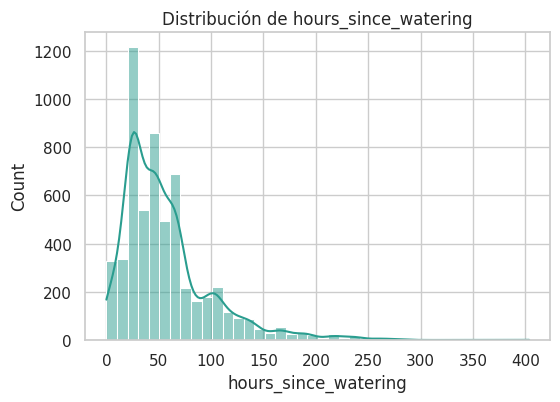

In [20]:
# Distribución del objetivo
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(df[TARGET].dropna(), kde=True, bins=40, ax=ax, color='#2a9d8f')
ax.set_title('Distribución de hours_since_watering')
plt.show()

### Interpretación de la distribución del objetivo
- Asimetría a la derecha: más observaciones con pocas horas sin regar; posibles colas largas.
- Bimodalidad: sugiere distintos regímenes (p.ej. riego reciente vs. riego antiguo).
- Rango típico orientativo: compáralo con la ventana operativa (p.ej. 0–72 h) para contextualizar errores (MAE) posteriores.

In [21]:
# Tabla de correlaciones (Pearson y Spearman) del objetivo con cada sensor
sub = df[[TARGET] + sensor_cols].copy()
sub = sub.dropna(subset=[TARGET])
pearson = sub.corr(method='pearson')[TARGET].drop(labels=[TARGET])
spearman = sub.corr(method='spearman')[TARGET].drop(labels=[TARGET])
corr_df = pd.DataFrame({
    'sensor': pearson.index,
    'pearson_r': pearson.values,
    'spearman_r': spearman.reindex(pearson.index).values
}).sort_values('pearson_r', ascending=False)
corr_df.head(20)

,sensor,pearson_r,spearman_r
7,sensor_soil_ph,0.809155,0.575295
2,sensor_wifi_rssi,0.455165,0.493771
5,sensor_soil_temp,0.243353,0.012255
3,sensor_co2,0.219535,0.146667
8,sensor_delta_minutes,0.014442,0.012693
4,sensor_light,-0.007749,-0.054023
0,sensor_humidity,-0.094929,-0.011395
1,sensor_voltage,-0.259584,-0.193478
6,sensor_soil_moisture,-0.562076,-0.934666


#### Magnitud de correlación (guía)
- |r| < 0.1: despreciable
- 0.1 ≤ |r| < 0.3: débil
- 0.3 ≤ |r| < 0.5: moderada
- |r| ≥ 0.5: fuerte
Nota: contextuales al dominio; correlación no implica causalidad.

### Cómo interpretar Pearson y Spearman
- Pearson mide correlación lineal; valores cercanos a ±1 indican relación lineal fuerte.
- Spearman mide correlación monotónica (basada en rangos), robusta a no linealidades y outliers.
- Diferencias entre ambos pueden sugerir relaciones no lineales o presencia de outliers.

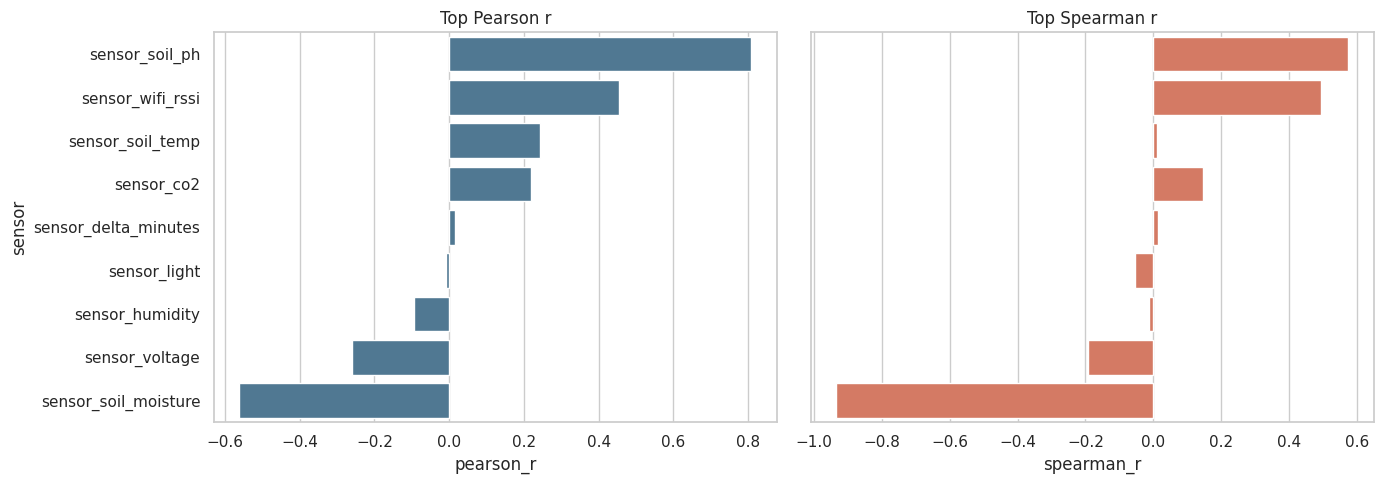

In [22]:
# Visualizar top-N sensores más correlacionados (barra)
TOPN = 15
top = corr_df.set_index('sensor').head(TOPN)
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)
sns.barplot(x=top['pearson_r'], y=top.index, ax=ax[0], color='#457b9d')
ax[0].set_title('Top Pearson r')
sns.barplot(x=top['spearman_r'], y=top.index, ax=ax[1], color='#e76f51')
ax[1].set_title('Top Spearman r')
plt.tight_layout()
plt.show()

### Lectura de los tops de correlación
- Barras positivas: mayor valor del sensor asociado a más horas sin regar.
- Barras negativas: mayor valor del sensor asociado a menos horas sin regar.
- Considera la magnitud y la coherencia con Spearman; valida con scatterplots.

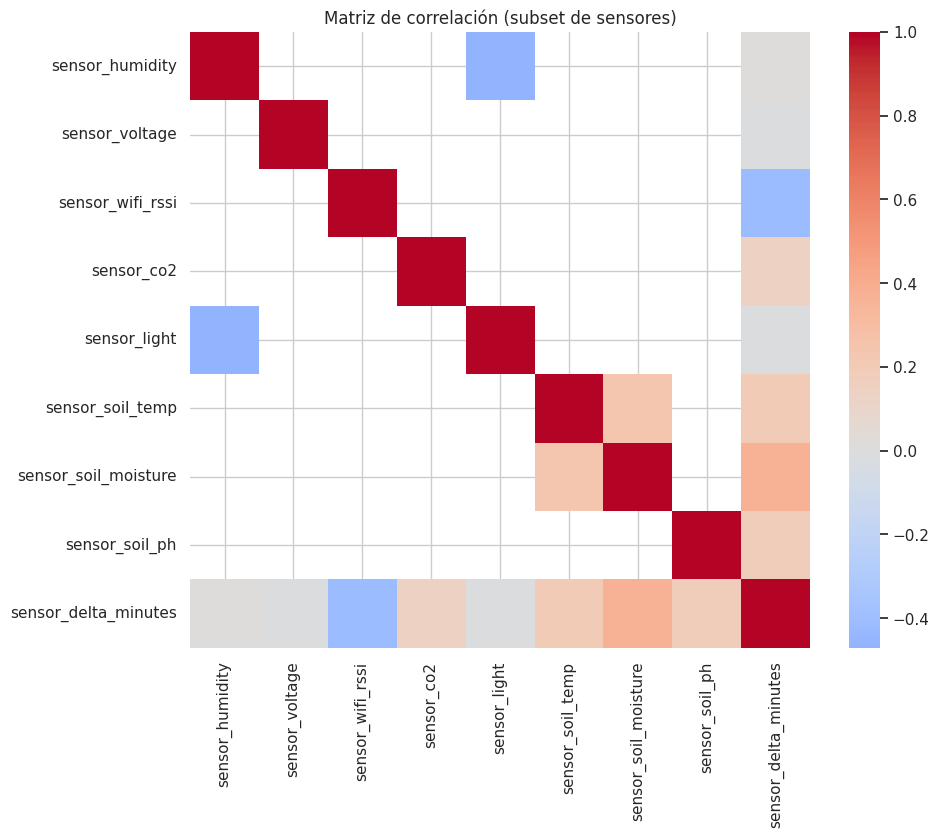

In [23]:
# Heatmap de correlaciones entre sensores (puede ser pesado si hay muchas columnas)
MAX_SENSORS_HEATMAP = 30
heat_cols = sensor_cols[:MAX_SENSORS_HEATMAP]
corr_mat = df[heat_cols].corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de correlación (subset de sensores)')
plt.show()

### Multicolinealidad entre sensores
- Bloques rojos/azules intensos indican sensores muy correlacionados (posible redundancia).
- Alta multicolinealidad puede sesgar modelos lineales e inflar varianzas.
- Estrategias: selección de variables, PCA, o modelos tree/boosting menos sensibles.

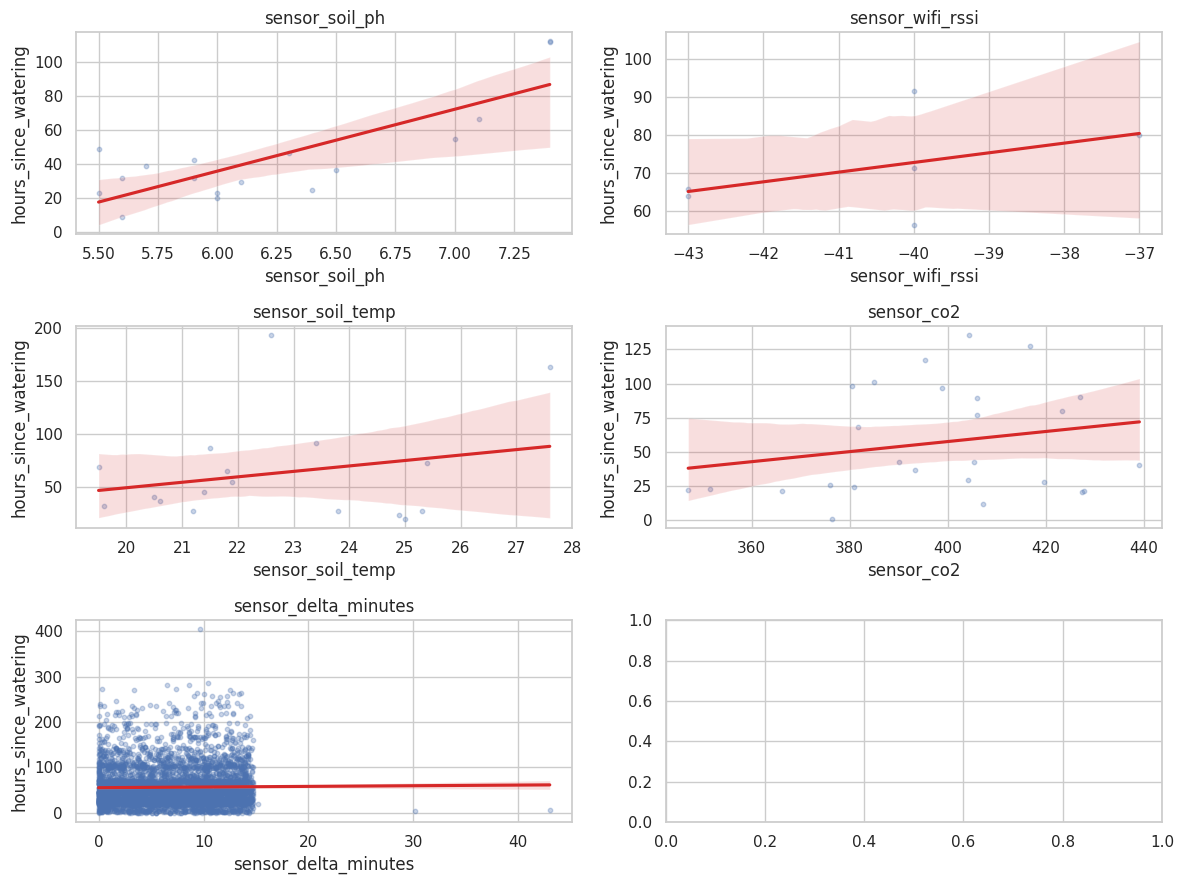

In [24]:
# Scatterplots con regresión para los 5 sensores más correlacionados (Pearson)
k = 5
top5 = corr_df['sensor'].head(k).tolist()
fig, axes = plt.subplots(nrows=(k+1)//2, ncols=2, figsize=(12, 3*((k+1)//2)))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
for i, col in enumerate(top5):
    ax = axes[i]
    sns.regplot(data=df, x=col, y=TARGET, scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'#d62828'}, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

### Scatter con regresión
- La pendiente indica tendencia media; la nube muestra dispersión y no linealidades.
- Observa curvaturas, saturaciones y outliers que puedan afectar modelos.
- Considera transformaciones (log, cuadrática) o modelos no lineales si procede.

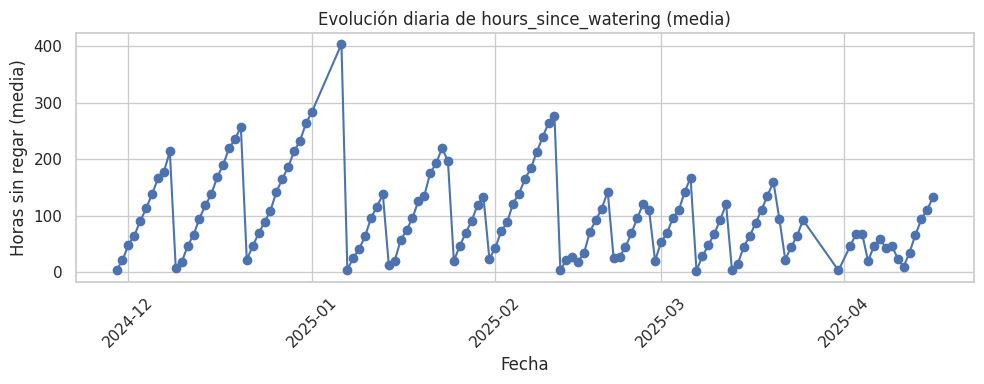

In [25]:
# (Opcional) Análisis temporal si existe 'recording_time'
if 'recording_time' in df.columns:
    df['_rt'] = pd.to_datetime(df['recording_time'], errors='coerce')
    tmp = df.dropna(subset=['_rt', TARGET]).copy()
    tmp['_date'] = tmp['_rt'].dt.date
    daily = tmp.groupby('_date')[TARGET].agg(['count','mean','median']).reset_index()
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(daily['_date'], daily['mean'], marker='o')
    ax.set_title('Evolución diaria de hours_since_watering (media)')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Horas sin regar (media)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    df.drop(columns=['_rt','_date'], errors='ignore', inplace=True)
else:
    print('No hay columna recording_time para análisis temporal.')

## Notas
- El TOP de correlaciones da una idea de qué sensores covarían más con `hours_since_watering`.
- Considera estandarizar sensores y usar modelos regulares para evaluar importancia (Lasso/Tree SHAP) en otro cuaderno si es necesario.
- Puedes filtrar por `channel` o `session` y recomputar correlaciones segmentadas.

## Importancia de características

A continuación se estima la importancia de los sensores para predecir `hours_since_watering` usando distintos enfoques:
- Lasso (importancia = |coeficientes| tras estandarizar)
- RandomForest (importancia basada en reducción de impureza)
- XGBoost (ganancia)
- Permutation Importance (degradación de rendimiento al permutar cada variable)


In [26]:
# Preparación de datos para importancia de características
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Variables X (sensores numéricos) e y (objetivo)
X = df[sensor_cols].copy()
y = df[TARGET].copy()

# Eliminamos filas con NaN en y y rellenamos sensores con la mediana
mask = y.notna()
X = X[mask]
y = y[mask]
X = X.fillna(X.median(numeric_only=True))

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización para modelos lineales
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

X_train.shape, X_val.shape

((4650, 9), (1163, 9))

### Preparación para importancia
- Se imputan sensores con la mediana (robusta) y se separan conjuntos train/validación.
- Se estandarizan características para Lasso (evita que la escala domine los coeficientes).
- Las importancias se calculan usando únicamente columnas `sensor_*`.

In [27]:
# Importancia con Lasso (L1)
from sklearn.linear_model import LassoCV
import pandas as pd

lasso = LassoCV(cv=5, random_state=42, n_jobs=None)
lasso.fit(X_train_std, y_train)
coef_abs = np.abs(lasso.coef_)
imp_lasso = pd.DataFrame({
    'sensor': X_train.columns,
    'importance': coef_abs
}).sort_values('importance', ascending=False)

imp_lasso.head(15)

,sensor,importance
1,sensor_voltage,5.256779
6,sensor_soil_moisture,1.143820
0,sensor_humidity,0.986038
5,sensor_soil_temp,0.746977
8,sensor_delta_minutes,0.535300
4,sensor_light,0.514442
7,sensor_soil_ph,0.474958
3,sensor_co2,0.249866
2,sensor_wifi_rssi,0.000000


In [28]:
# Importancia con RandomForest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
imp_rf = pd.DataFrame({
    'sensor': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

imp_rf.head(15)

,sensor,importance
8,sensor_delta_minutes,0.629568
0,sensor_humidity,0.143605
4,sensor_light,0.106886
1,sensor_voltage,0.104866
6,sensor_soil_moisture,0.005616
3,sensor_co2,0.005489
7,sensor_soil_ph,0.002343
5,sensor_soil_temp,0.001407
2,sensor_wifi_rssi,0.000221


In [29]:
# Importancia con XGBoost (ganancia)
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
booster = xgb.get_booster()
# importance_types: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
score = booster.get_score(importance_type='gain')
imp_xgb = pd.DataFrame({
    'sensor': list(score.keys()),
    'importance': list(score.values())
}).sort_values('importance', ascending=False)

imp_xgb.head(15)

,sensor,importance
6,sensor_soil_moisture,2376.237061
1,sensor_voltage,2295.300537
8,sensor_delta_minutes,1834.481201
4,sensor_light,1644.465942
0,sensor_humidity,1590.052490
7,sensor_soil_ph,718.820557
3,sensor_co2,661.965332
5,sensor_soil_temp,589.408997
2,sensor_wifi_rssi,189.024689


In [30]:
# Permutation Importance (en validación)
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error

# Usamos el RandomForest entrenado (robusto a escalado)
base_mae = mean_absolute_error(y_val, rf.predict(X_val))
perm = permutation_importance(rf, X_val, y_val, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error', n_jobs=-1)
imp_perm = pd.DataFrame({
    'sensor': X_val.columns,
    'importance': perm.importances_mean
}).sort_values('importance', ascending=False)

base_mae, imp_perm.head(15)

(31.727027989525414,
                  sensor  importance
 0       sensor_humidity    2.995551
 4          sensor_light    2.446649
 1        sensor_voltage    1.811852
 8  sensor_delta_minutes    0.335948
 7        sensor_soil_ph    0.027320
 5      sensor_soil_temp    0.001163
 2      sensor_wifi_rssi    0.000000
 6  sensor_soil_moisture   -0.002177
 3            sensor_co2   -0.009624)

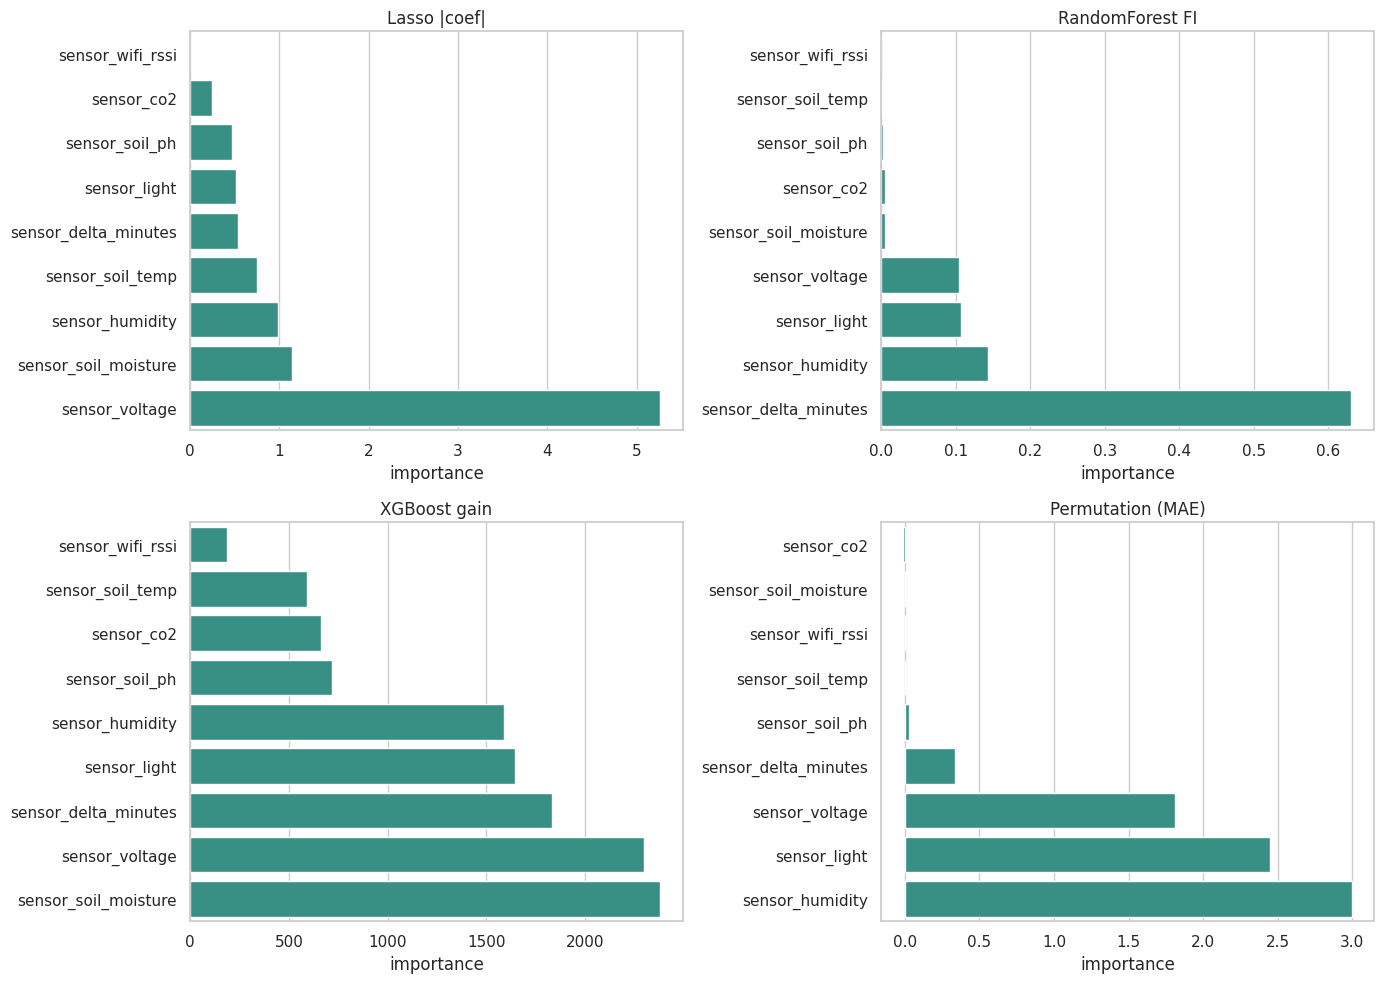

In [31]:
# Gráficos comparativos de importancias (Top 15)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (title, df_imp) in zip(axes.flatten(), [
    ('Lasso |coef|', imp_lasso),
    ('RandomForest FI', imp_rf),
    ('XGBoost gain', imp_xgb),
    ('Permutation (MAE)', imp_perm)
]):
    top = df_imp.head(15).iloc[::-1]
    sns.barplot(x='importance', y='sensor', data=top, ax=ax, color='#2a9d8f')
    ax.set_title(title)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

### Interpretación de importancias
- Lasso: sensible a escala (estandarizado) y colinealidad; coeficientes ~0 implican poca contribución lineal.
- RandomForest/XGBoost: capturan no linealidad e interacciones; importancias pueden concentrarse en pocas variables.
- Permutation: estima impacto en la métrica (MAE); valores más altos sugieren variables críticas.
- Acciones: seleccionar top-k variables, eliminar redundantes, o diseñar features derivadas (p.ej. ratios).

## Interpretabilidad con SHAP

Calculamos valores SHAP para interpretar la contribución de cada sensor a la predicción de `hours_since_watering`.
Se incluyen gráficos de resumen (bar y beeswarm) para RandomForest y XGBoost.

In [32]:
# (Opcional) Instalar SHAP si no está disponible
try:
    import shap  # noqa: F401
except ImportError:
    import sys, subprocess
    print('Instalando shap...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap'])
    import shap

Instalando shap...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/996.4 kB ? eta -:--:--Requirement already satisfied: numba>=0.54 in /home/gti/.conda/envs/ibmcp/lib/python3.10/site-packages (from shap) (0.61.2)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.4/996.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.4/996.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 1/2 [shap]Installing collected packages: slicer, shap
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]1/2 [shap]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]


SHAP RandomForest:


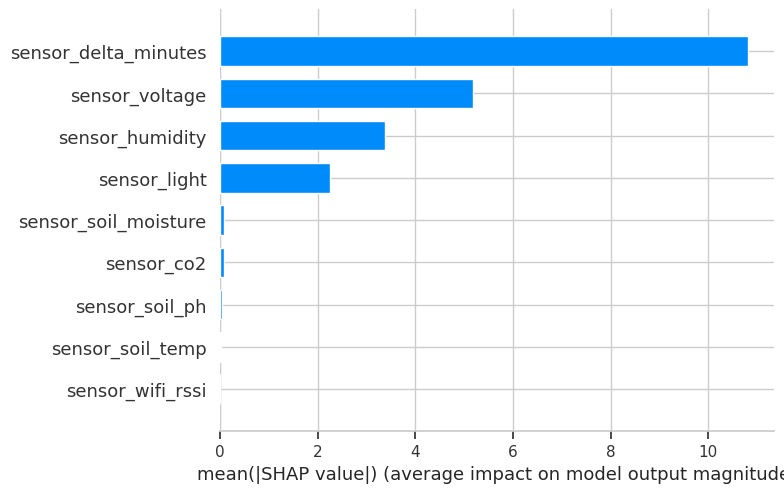

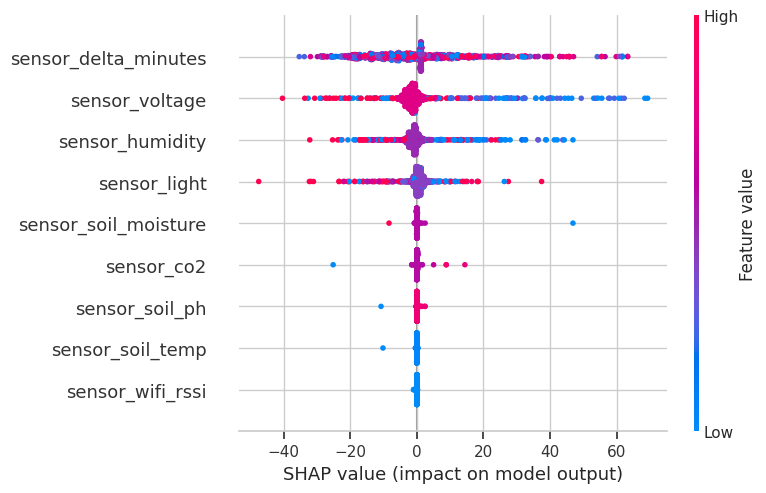

SHAP XGBoost:


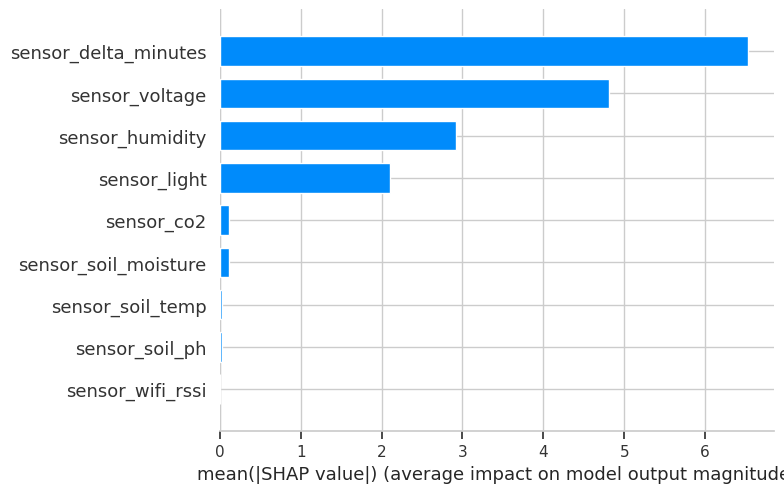

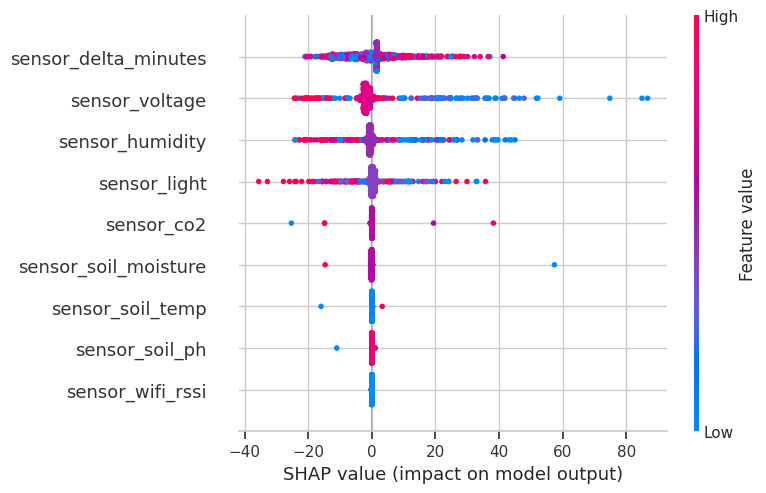

In [33]:
# SHAP para RandomForest y XGBoost
import shap
shap.initjs()

# Tomamos una muestra para acelerar
SAMPLE = min(1000, len(X_val))
X_val_sample = X_val.sample(SAMPLE, random_state=42)

# RandomForest (TreeExplainer)
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_val_sample)

print('SHAP RandomForest:')
shap.summary_plot(shap_values_rf, X_val_sample, plot_type='bar', show=False)
plt.show()
shap.summary_plot(shap_values_rf, X_val_sample, show=False)
plt.show()

# XGBoost (TreeExplainer)
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_val_sample)

print('SHAP XGBoost:')
shap.summary_plot(shap_values_xgb, X_val_sample, plot_type='bar', show=False)
plt.show()
shap.summary_plot(shap_values_xgb, X_val_sample, show=False)
plt.show()

### Interpretación de SHAP y PDP
- SHAP bar: ranking global de contribuciones absolutas; beeswarm: distribución y signo por muestra.
- Valores SHAP positivos aumentan la predicción (más horas sin regar), negativos la reducen.
- PDP: muestra el efecto medio aislado de una variable sobre la predicción; no capta interacciones complejas.
- Usa SHAP dependence plots para ver interacciones si fuese necesario.

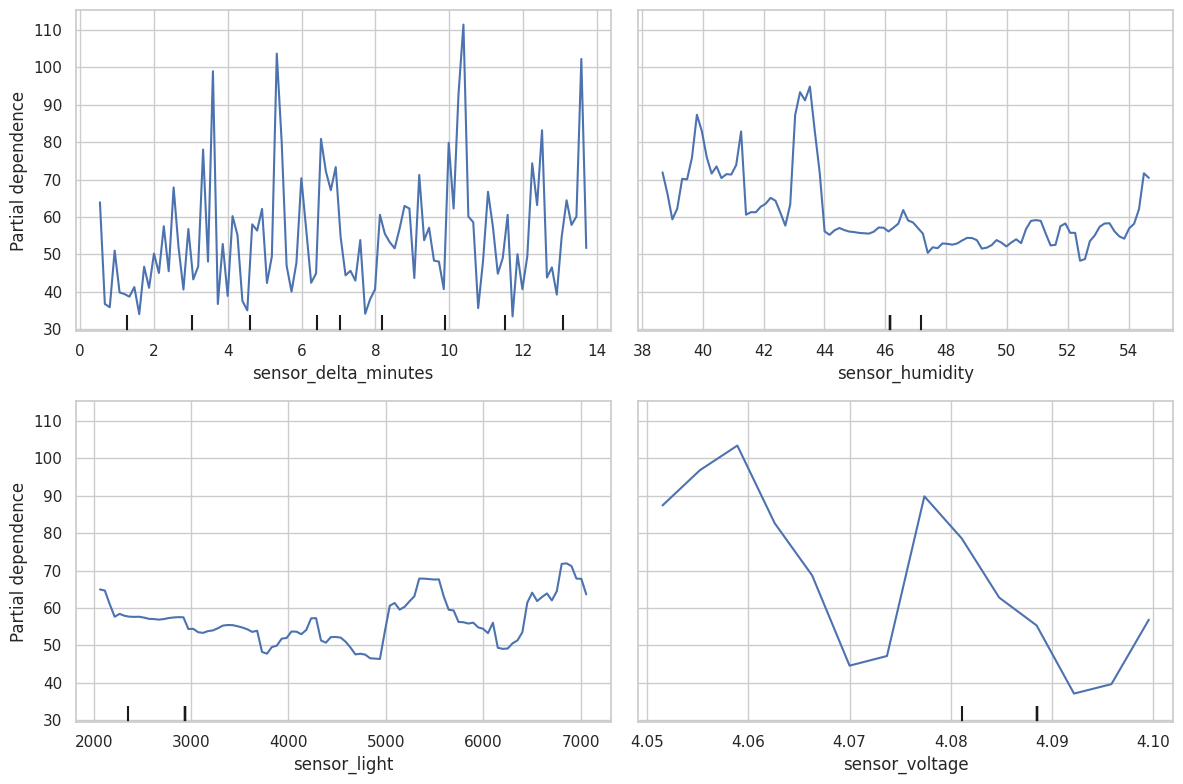

In [34]:
# Partial Dependence Plots (PDP) para los sensores más relevantes
from sklearn.inspection import PartialDependenceDisplay

# Elegimos los top 4 por RandomForest
top4 = imp_rf['sensor'].head(4).tolist()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf, X_val, features=top4, ax=ax)
plt.tight_layout()
plt.show()